# Objectives

1. Estimate Clock Model
1. Filter Outliers
    - Plot Prune Compare: Divtree
    - Plot Prune Compare: Timetree
1. Add Clock Model to Dataframe

NOTE: Filter outliers after clock model estimated?

---
# Setup

## Modules

In [37]:
# Bio
import treetime
from Bio import Phylo

# Plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set_style('whitegrid')

# Stats
import pandas as pd

# System IO
import dill
import copy
import os
import io
import sys

## Variables

In [38]:
from config import *

# Custom script variables
SCRIPT_NAME = "clock"
PREV_DIR_NAME = "parse_tree"
PREV_SCRIPT_NAME = "parse_tree"

try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    WILDCARDS = ["all", "chromosome", "5"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
MISSING_DATA = WILDCARDS[2]

NAME_COL = "Name"

## Paths

In [39]:
results_dir = os.path.join(project_dir, "results")
config_dir = os.path.join(results_dir, "config")


outdir       = os.path.join(results_dir, SCRIPT_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),)
tree_dill    = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),PREV_SCRIPT_NAME + ".phylo.obj")
tree_df_dill = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".df.obj")
tree_df_path = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".tsv")
aln_path     = os.path.join(results_dir,"snippy_multi",READS_ORIGIN,"snippy-core_{}.snps.filter{}.aln".format(LOCUS_NAME, MISSING_DATA))


# Auspice
auspice_latlon_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_latlon.tsv")
auspice_colors_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_colors.tsv")
auspice_config_path = os.path.join(config_dir, "auspice_config.json")
auspice_remote_dir_path = os.path.join(project_dir, "auspice/")

constant_sites_path = os.path.join(results_dir,"snippy_multi",READS_ORIGIN,"snippy-core_chromosome.full.constant_sites.txt")


print("tree_dill:\t", tree_dill)
print("tree_df_dill:\t", tree_df_dill)
print("aln path:\t", aln_path)
print("auspice_latlon_path:", auspice_latlon_path)
print("auspice_colors_path:", auspice_colors_path)
print("auspice_config_path:", auspice_config_path)
print("auspice_remote_dir_path:", auspice_remote_dir_path)
print("outdir:", outdir)

# Create output directory if it doesn't exist
while not os.path.exists(outdir):
    os.makedirs(outdir)   
    
SCRIPT_NAME = "clock_model"

tree_dill:	 /2/scratch/keaton/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree.phylo.obj
tree_df_dill:	 /2/scratch/keaton/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree.df.obj
aln path:	 /2/scratch/keaton/plague-phylogeography/results/snippy_multi/all/snippy-core_chromosome.snps.filter5.aln
auspice_latlon_path: /2/scratch/keaton/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree_latlon.tsv
auspice_colors_path: /2/scratch/keaton/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree_colors.tsv
auspice_config_path: /2/scratch/keaton/plague-phylogeography/results/config/auspice_config.json
auspice_remote_dir_path: /2/scratch/keaton/plague-phylogeography/auspice/
outdir: /2/scratch/keaton/plague-phylogeography/results/clock/all/chromosome_filter5


## Import Tree

In [40]:
with open(tree_dill, "rb") as infile:
    tree = dill.load(infile)
tree.ladderize(reverse=False)

## Import Dataframe

In [41]:
with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number
Name,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0.000000e+00,black,0.000000,17.125758,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.840800e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0
NODE1,100,84.9,1.342240e-05,black,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.233000e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0
NODE2,100,94.7,1.347620e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE611,34,15.9,2.345000e-07,black,0.000076,613.750000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
GCA_000268845.1_ASM26884v1_genomic,NA,NA,2.340000e-08,grey,0.000076,613.000000,PY-56,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141479,KEEP: Assembly Modern,1
NODE612,44,93.8,2.345000e-07,black,0.000077,614.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Import Constant Sites

In [42]:
with open(constant_sites_path, "r") as infile:
    constant_sites_str = infile.read().strip().split(",")
    constant_sites_list = [int(c) for c in constant_sites_str]
    constant_sites = sum(constant_sites_list)
    constant_sites_freq = [c/constant_sites for c in constant_sites_list]
    # Add element for "-"
    fixed_pi = np.array(constant_sites_freq + [0])

# 1. Filter Outlier Tips

## Parse Tip Dates

In [43]:
# Use the utils function to parse the metadata dates
dates_raw = treetime.utils.parse_dates(tree_df_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)

# Remove nan elements (internal nodes)
dates = {}
for k,v in dates_raw.items():
    if type(v) == list:
        dates[k] = v
    elif not pd.isnull(v):
        dates[k] = v
        
# Add Reference
dates["Reference"] = REF_DATE


Attempting to parse dates...
	Using column 'Name' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.


---
# 1. Estimate Clock Model

## Initialize treetime object

In [44]:
tt = treetime.TreeTime(dates=dates, 
                       aln=aln_path,                     
                       tree=tree, 
                       verbose=3, 
                       fill_overhangs=False,
                       seq_len=REF_LEN,
                      )
#tt.tree.root.branch_length = 0.000001


0.00	-TreeAnc: set-up

1.26	-SequenceData: loaded alignment.
1.27	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

1.27	-SeqData: making compressed alignment...

5.00	-SequenceData: constructed compressed alignment...
5.38	--ClockTree: Setting precision to level 2

5.47	-ClockTree._assign_dates: assigned date contraints to 615 out of 615 tips.


## Estimate the clock model

In [86]:
#tt.run(max_iter=1)
tt.run(
    # Run Parameters
    max_iter=10,    
    verbose=3,
    # Clock Rate
    use_covariation=False,            
    vary_rate=True,    
    relaxed_clock={"slack" : 0.1, "coupling": 0}, 
    time_marginal=True,   # True, False or "assign"     
    # Substituion Model
    infer_gtr=True,
    fixed_pi=fixed_pi,
    # Tree structure
    n_iqd=3,     
    branch_length_mode = "joint", # joint or marginal          
    root=tt.tree.root,      
    resolve_polytomies=True,   
    Tc="skyline", 
    #n_points=40, # Transition points in skyline, 20 is default     
    )

# Order nodes
tt.tree.ladderize(reverse=False)

# Add extra length to root
tt_orig = copy.deepcopy(tt)


1445.33	-TreeTime._set_branch_length_mode: maximum branch length is 3.308e-05,
       	 using branch length mode joint

1445.33	-TreeAnc.optimize_tree: sequences...

1445.33	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint
1445.33	--TreeAnc.infer_gtr: counting mutations...

1446.92	-GTR: with alphabet: ['A', 'C', 'G', 'T', '-']
1446.92	--GTR: ambiguous character: N

1446.92	-GTR: model inference
1446.92	--The model allows for gaps which are estimated to occur at a low
       	  fraction of 0.000e+00 this can potentially result in artificats. gap
       	  fraction will be set to 0.0100
1446.92	--TreeAnc.infer_gtr: setting overall rate to 1.0...
1446.92	--TreeAnc._ml_anc_joint: type of reconstruction: Joint

1455.43	-TreeAnc.optimize_branch_length: running branch length optimization
       	 using jointML ancestral sequences

1460.61	-TreeAnc.prune_short_branches: pruning short branches (max prob at
       	 zero)...

1460.86	-TreeAnc.infer_ancestral_sequences with 

## Quick Checks

In [46]:
# Common Ancestor
tt.tree.common_ancestor("NODE0")

Clade(_v=0, bad_branch=False, branch_length=0.001, clock_length=0.001, comment='&UFboot=100.0,sCF=NA,Branch_Length=0.0,Branch_Support_Col...', date='-4165-09-28', dist2root=0.0, mutation_length=0.001, name='NODE0', original_length=0.0)

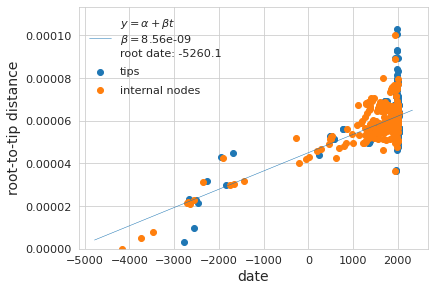

In [47]:
# RTT Regression
tt.plot_root_to_tip(add_internal=True, label=True)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rtt-pre." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

In [93]:
print(tt.gtr)

tt.print_lh()

Substitution rate (mu): 1.0

Equilibrium frequencies (pi_i):
  A: 0.2601
  C: 0.2341
  G: 0.2366
  T: 0.2593
  -: 0.0099

Symmetrized rates from j->i (W_ij):
	A	C	G	T	-
  A	0	0.1989	0.2573	0.1152	67.2238
  C	0.1989	0	0.0521	0.2597	105.5911
  G	0.2573	0.0521	0	0.2175	96.2987
  T	0.1152	0.2597	0.2175	0	82.288
  -	67.2238	105.5911	96.2987	82.288	0

Actual rates from j->i (Q_ij):
	A	C	G	T	-
  A	0	0.0517	0.0669	0.03	17.4839
  C	0.0465	0	0.0122	0.0608	24.7137
  G	0.0609	0.0123	0	0.0515	22.788
  T	0.0299	0.0673	0.0564	0	21.3392
  -	0.6656	1.0455	0.9535	0.8147	0

###  Tree Log-Likelihood  ###
 Sequence log-LH without constraints: 	-6725667.434
 Sequence log-LH with constraints:    	-6725701.331
 TreeTime sequence log-LH:            	-1010006639954.062
 Coalescent log-LH:                   	0.000
#########################


# 2. Filter Outliers

## Prune 'Bad' Branches from Tree

In [48]:
tt_pre = copy.deepcopy(tt)
tt_prune = copy.deepcopy(tt)

# Color branches and set to divtree
for n in tt_pre.tree.find_clades():
    n.branch_length=n.mutation_length
    if n.bad_branch:
        n.color = "red"
for n in tt_prune.tree.find_clades():
    n.branch_length=n.mutation_length

bad_nodes = [c for c in tt_prune.tree.find_clades() if c.bad_branch]

while len(bad_nodes) > 0:
    for node in bad_nodes:
        if node.is_terminal():
            print("PRUNING:", node.name)
            tt_prune.tree.prune(node)
    bad_nodes = [c for c in tt_prune.tree.find_clades() if c.bad_branch]

## Plot Prune Comparison: Divtree

In [71]:
# What's the average branch length?
branch_lengths = []
for c in tree.find_clades():
    branch_lengths.append(c.branch_length)

branch_lengths_mean = (sum(branch_lengths) / len(branch_lengths))

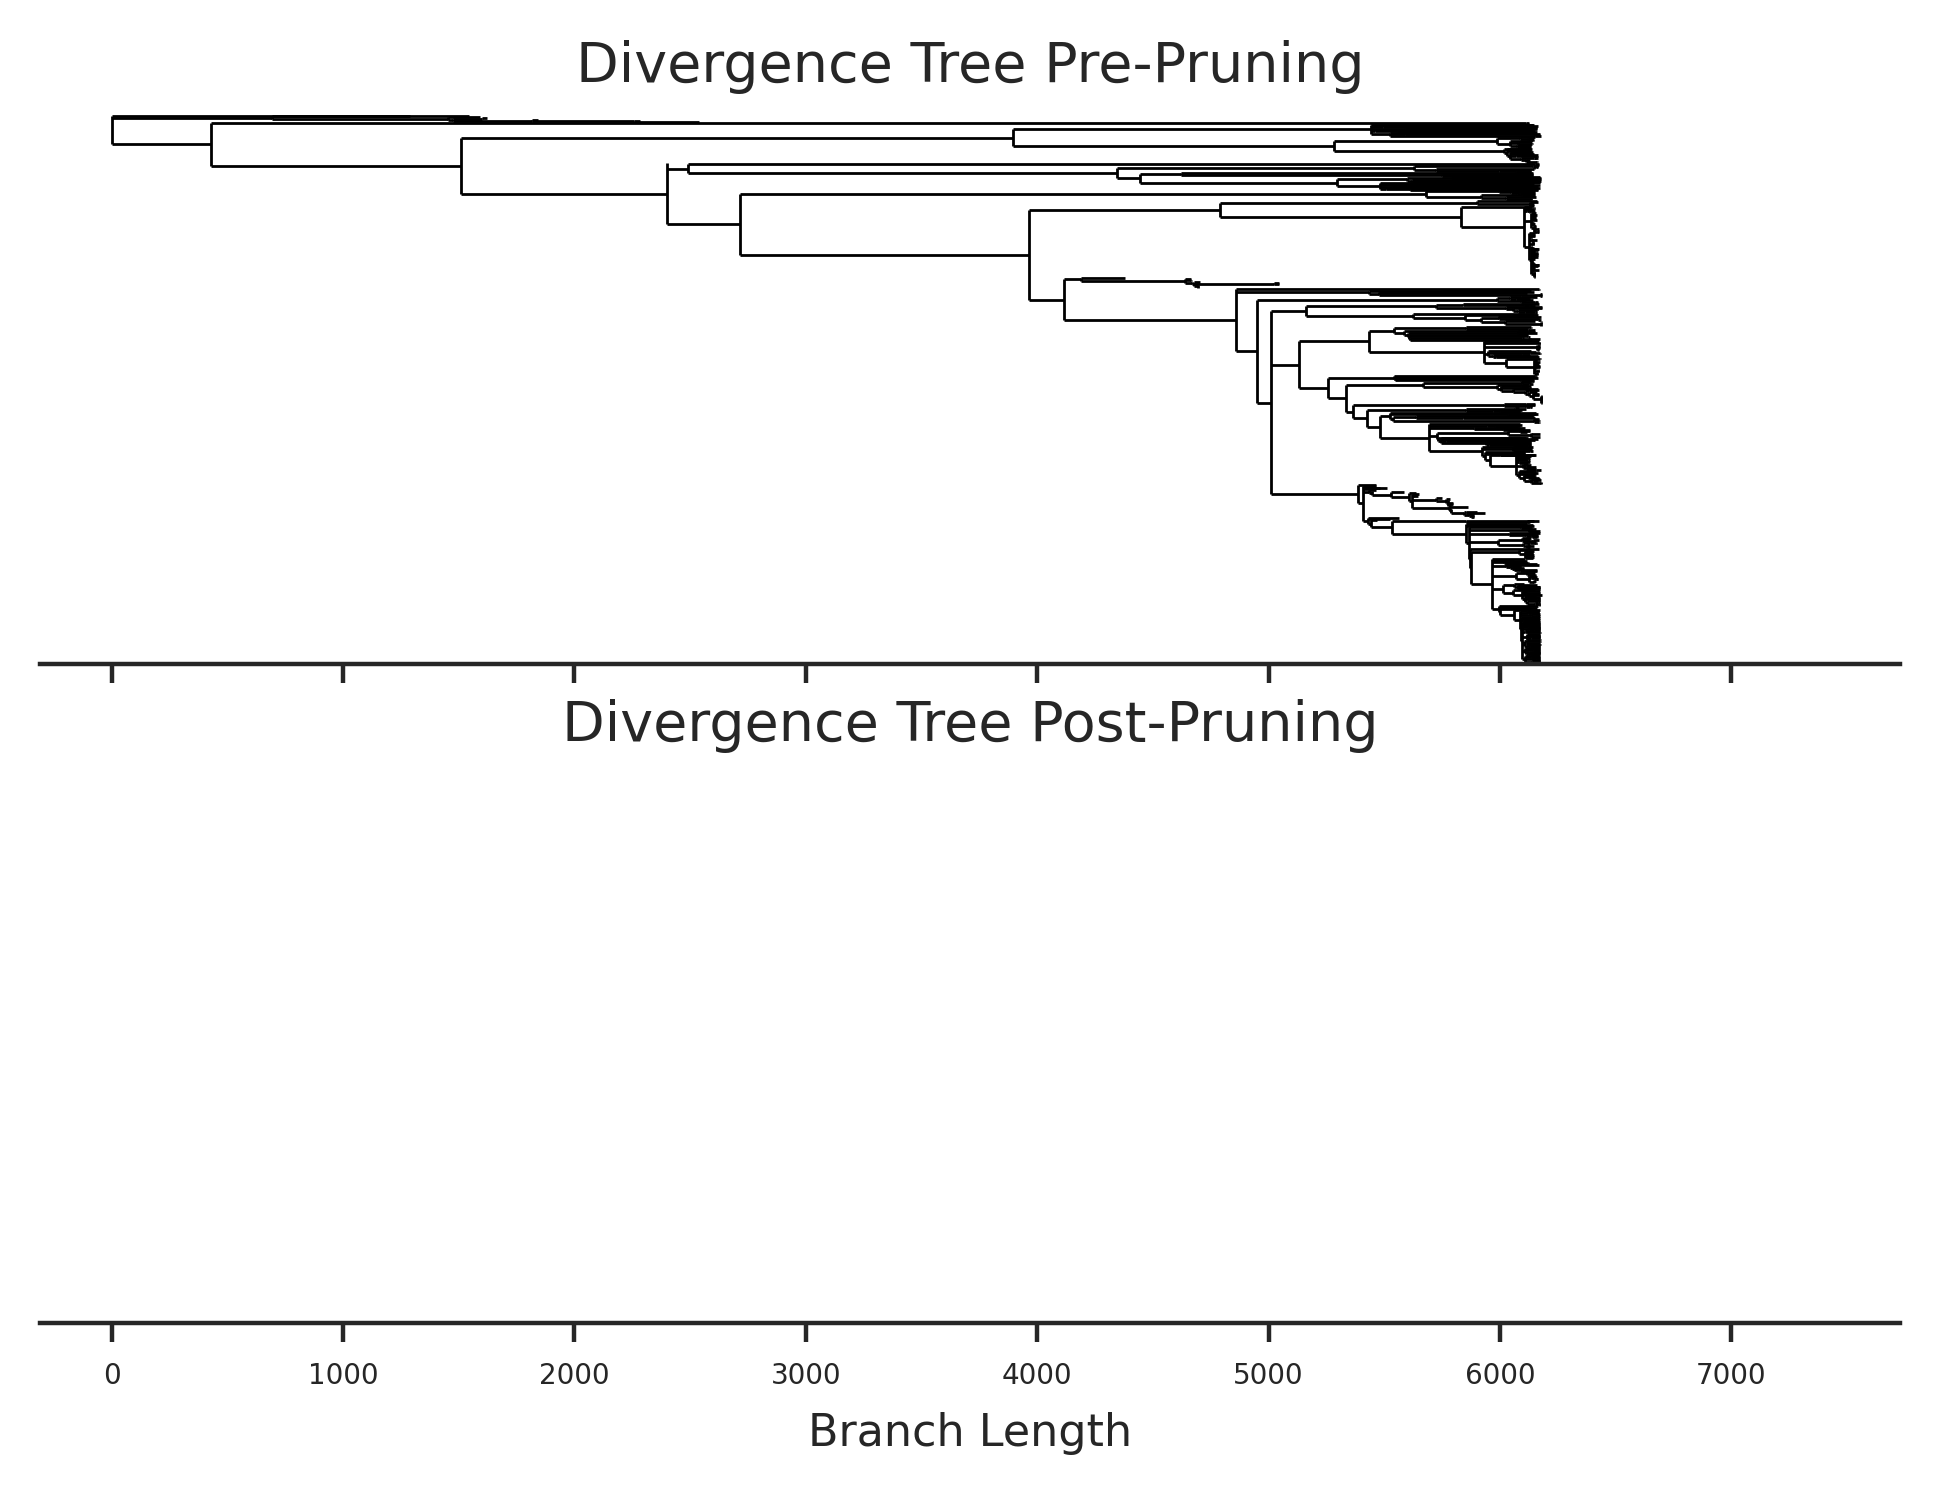

In [77]:
sns.set_style("ticks")
fig, (ax1,ax2) = plt.subplots(2, sharex=True, dpi=dpi)

#tt_pre.tree.root.branch_length = branch_lengths_mean
#tt_prune.tree.root.branch_length = branch_lengths_mean

Phylo.draw(tt_pre.tree,   show_confidence=False, label_func = lambda x: '', do_show=False, axes=ax1,)  
Phylo.draw(tt_prune.tree, show_confidence=False, label_func = lambda x: '', do_show=False, axes=ax2,)

ax1.set_title("Divergence Tree Pre-Pruning")
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_yticks([])
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)

ax2.set_title("Divergence Tree Post-Pruning")
ax2.set_xlabel("Branch Length")
ax2.set_ylabel("")
ax2.set_ylabel("")
ax2.set_yticks([])
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_visible(False)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_divtree-prune." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## Plot Prune Comparison: Timetree

191.55	--ClockTree.branch_length_to_years: setting node positions in units of
      	  years
206.02	--ClockTree.branch_length_to_years: setting node positions in units of
      	  years


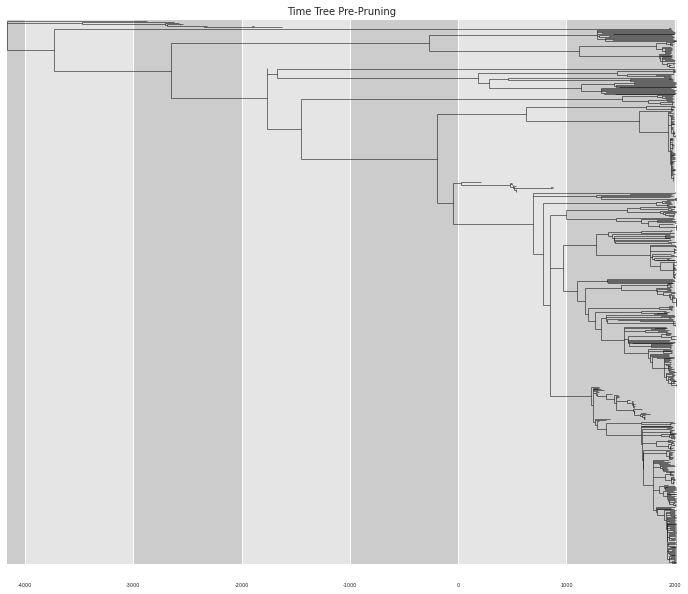

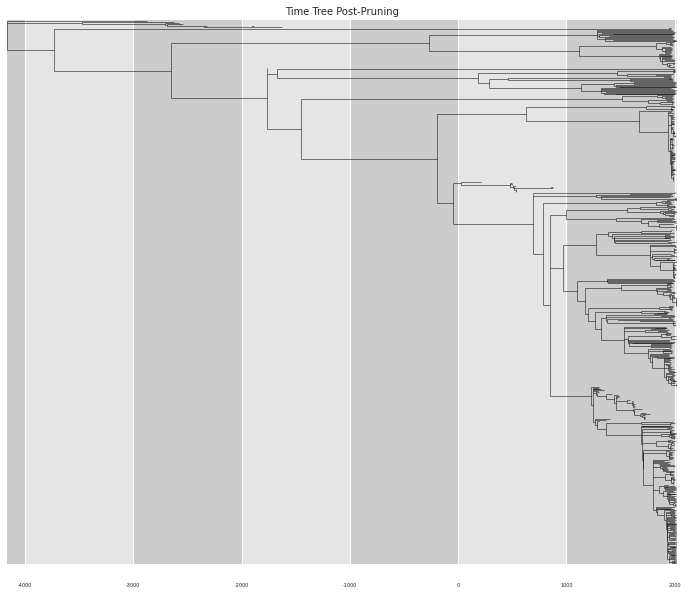

In [51]:
# Pre-pruning
if hasattr(tt.tree.root, "marginal_inverse_cdf"):
    fig, ax1 = treetime.treetime.plot_vs_years(tt_pre, label_func = lambda x:"", do_show=False, show_confidence=False, confidence=(1-CONFIDENCE, CONFIDENCE))
else:
    fig, ax1 = treetime.treetime.plot_vs_years(tt_pre, label_func = lambda x:"" ,do_show=False ,show_confidence=False)  

ax1.set_title("Time Tree Pre-Pruning")

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree-prune-pre." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

# Post-pruning    
if hasattr(tt.tree.root, "marginal_inverse_cdf"):
    fig, ax2 = treetime.treetime.plot_vs_years(tt_prune, label_func = lambda x:"", do_show=False, show_confidence=False, confidence=(1-CONFIDENCE, CONFIDENCE))
else:
    fig, ax2 = treetime.treetime.plot_vs_years(tt_prune, label_func = lambda x:"" ,do_show=False, show_confidence=False)  

ax2.set_title("Time Tree Post-Pruning")

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree-prune-post." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## Update tt variable

In [52]:
tt = tt_prune

## Remove Collapsed Nodes from Dataframe

In [53]:
tt_nodes = [c.name for c in tt.tree.find_clades()]
for rec in tree_df.iterrows():
    node = rec[0]
    if node not in tt_nodes:
        tree_df.drop(node, inplace=True)
        
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number
Name,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0.000000e+00,black,0.000000,17.125758,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.840800e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0
NODE1,100,84.9,1.342240e-05,black,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.233000e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0
NODE2,100,94.7,1.347620e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE611,34,15.9,2.345000e-07,black,0.000076,613.750000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
GCA_000268845.1_ASM26884v1_genomic,NA,NA,2.340000e-08,grey,0.000076,613.000000,PY-56,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141479,KEEP: Assembly Modern,1
NODE612,44,93.8,2.345000e-07,black,0.000077,614.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


---
# 3. Add Clock Model to Dataframe

- Rates
- Dates
- RTT Regression
- Skyline
- coord_x and coord_y

## Rates

In [54]:
tree_df["timetree_rate"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_rate_fold_change"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_mutation_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# The mean rate is the slope
mean_rate = tt.clock_model["slope"]

for c in tt.tree.find_clades():
    tree_df.at[c.name, "timetree_mutation_length"] = c.mutation_length
    
    # Relaxed Clock
    if hasattr(c, "branch_length_interpolator") and c.branch_length_interpolator:
        g = c.branch_length_interpolator.gamma
        tree_df.at[c.name, "timetree_rate_fold_change"] = g
        tree_df.at[c.name, "timetree_rate"] = mean_rate * g
        
    # Strict Clock
    else:
        tree_df.at[c.name, "timetree_rate_fold_change"] = 1
        tree_df.at[c.name, "timetree_rate"] = mean_rate

## Dates

In [55]:
# Create new columns
tree_df["timetree_raw_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_num_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

if hasattr(tt.tree.root, "marginal_inverse_cdf"):
    tree_df["timetree_num_date_confidence"] = [[NO_DATA_CHAR,NO_DATA_CHAR] for row in range(0,len(tree_df))]
    tree_df["timetree_num_date_bar"] = [[NO_DATA_CHAR,NO_DATA_CHAR] for row in range(0,len(tree_df))]
    
# clock_length is the same as branch_length until running branch_length_to_years()
tree_df["timetree_clock_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# Make a copy to change branch_length
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

CONF_BAD_RANGE = 10000
CONF_EXTREME = 100000
bad_conf = [["node", "lower_bad", "upper_bad", "lower_corrected", "upper_corrected"]]
        
for c in tt_copy.tree.find_clades():
    # Marginal Probability
    if hasattr(c, "marginal_inverse_cdf"):   
        # Retrieve the region containing the confidence interval
        conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE)
        conf_range = abs(conf[1] - conf[0])
        if conf_range > CONF_BAD_RANGE or conf[0] < -CONF_EXTREME or conf[1] > CONF_EXTREME:
            conf[0] = c.numdate
            conf[1] = c.numdate 
        
        # Set as lower and upper bounds on date
        tree_df.at[c.name, "timetree_num_date_confidence"][0] = conf[0]
        tree_df.at[c.name, "timetree_num_date_confidence"][1] = conf[1]
        
        # Convert to YBP present for drawing bars
        tree_df.at[c.name, "timetree_num_date_bar"][0] = CURRENT_YEAR - conf[0]
        tree_df.at[c.name, "timetree_num_date_bar"][1] = CURRENT_YEAR - conf[1]
        
    tree_df.at[c.name, "timetree_raw_date"] = c.date  
    tree_df.at[c.name, "timetree_num_date"] = c.numdate
    tree_df.at[c.name, "timetree_clock_length"] = c.branch_length
    
out_path_bad_conf = os.path.join(outdir, SCRIPT_NAME + "_bad-confidence.tsv")
with open(out_path_bad_conf, "w") as outfile:
    for node in bad_conf:
        outfile.write("\t".join([str(n) for n in node]) + "\n")

241.35	--ClockTree.branch_length_to_years: setting node positions in units of
      	  years


## RTT

In [56]:
# make a copy of the tree
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

# Plotting the tree
tree_df["timetree_coord_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_coord_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))] 

# Plotting the regression
tree_df["timetree_reg_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_bad"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)
tt_reg = tt_copy.setup_TreeRegression()

# Add x and y coordinates
for c in tt_copy.tree.find_clades():     
        
    # Tree Node Coordinates
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    tree_df.at[c.name, 'timetree_coord_x'] = coord_x
    tree_df.at[c.name, 'timetree_coord_y'] = coord_y
    
    # Regression Node Coordinates
    reg_y = c._v
    if c.is_terminal():
        reg_x = tt_reg.tip_value(c)
    else:
        reg_x = c.numdate
    reg_bad = c.bad_branch  if hasattr(c, 'bad_branch') else False
    tree_df.at[c.name, 'timetree_reg_x'] = reg_x
    tree_df.at[c.name, 'timetree_reg_y'] = reg_y    
    tree_df.at[c.name, 'timetree_reg_bad'] = reg_bad

# Fix up new values that could be none
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df

242.23	--ClockTree.branch_length_to_years: setting node positions in units of
      	  years


,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0.000000e+00,black,0.000000,17.125758,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.561598e-09,1.0,1.000000e-03,-4165-09-28,-4164.258043,0.100000,0.100000,17.132882,-4164.258043,0.000000,False
SAMEA3541827,NA,NA,3.840800e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,8.561598e-09,1.0,3.313805e-06,-2876-01-01,-2875.999883,1288.258159,1288.358159,1.000000,-2776.500000,0.000003,False
NODE1,100,84.9,1.342240e-05,black,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.561598e-09,1.0,7.878048e-06,-3470-02-03,-3469.907362,694.350680,694.450680,3.156250,-3469.907362,0.000008,False
SAMEA104233046,NA,NA,2.233000e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,8.561598e-09,1.0,1.864012e-06,-2621-01-01,-2620.999883,848.907479,1543.358159,2.000000,-2546.500000,0.000010,False
NODE2,100,94.7,1.347620e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.561598e-09,1.0,1.349354e-05,-2711-01-25,-2710.932840,758.974522,1453.425203,4.312500,-2710.932840,0.000021,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE611,34,15.9,2.345000e-07,black,0.000076,613.750000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.561598e-09,1.0,2.069645e-07,1956-11-27,1956.906102,18.008681,6121.264145,595.750000,1956.906102,0.000066,False
GCA_000268845.1_ASM26884v1_genomic,NA,NA,2.340000e-08,grey,0.000076,613.000000,PY-56,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141479,KEEP: Assembly Modern,1,8.561598e-09,1.0,1.625686e-22,2010-01-01,2010.000000,53.093898,6174.358043,595.000000,2010.000000,0.000066,False
NODE612,44,93.8,2.345000e-07,black,0.000077,614.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.561598e-09,1.0,2.069780e-07,1967-01-23,1967.061231,10.155129,6131.419274,596.500000,1967.061231,0.000066,False


## Divergence coord_x and coord_y

In [57]:
tt_copy = copy.deepcopy(tt)
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length
    
x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)

# Add x and y coordinates as other attributes
for c in tt_copy.tree.find_clades():
    # x coordinates will be of branch length units
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    # y coordinates will be arbitrary, based on number of tips
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    # Update coordinates in dataframe
    tree_df.at[c.name, 'coord_x'] = coord_x
    tree_df.at[c.name, 'coord_y'] = coord_y    

# Visualize dataframe
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0.000000e+00,black,0.001000,17.132882,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.561598e-09,1.0,1.000000e-03,-4165-09-28,-4164.258043,0.100000,0.100000,17.132882,-4164.258043,0.000000,False
SAMEA3541827,NA,NA,3.840800e-06,grey,0.001003,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,8.561598e-09,1.0,3.313805e-06,-2876-01-01,-2875.999883,1288.258159,1288.358159,1.000000,-2776.500000,0.000003,False
NODE1,100,84.9,1.342240e-05,black,0.001008,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.561598e-09,1.0,7.878048e-06,-3470-02-03,-3469.907362,694.350680,694.450680,3.156250,-3469.907362,0.000008,False
SAMEA104233046,NA,NA,2.233000e-06,grey,0.001010,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,8.561598e-09,1.0,1.864012e-06,-2621-01-01,-2620.999883,848.907479,1543.358159,2.000000,-2546.500000,0.000010,False
NODE2,100,94.7,1.347620e-05,black,0.001021,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.561598e-09,1.0,1.349354e-05,-2711-01-25,-2710.932840,758.974522,1453.425203,4.312500,-2710.932840,0.000021,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE611,34,15.9,2.345000e-07,black,0.001066,595.750000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.561598e-09,1.0,2.069645e-07,1956-11-27,1956.906102,18.008681,6121.264145,595.750000,1956.906102,0.000066,False
GCA_000268845.1_ASM26884v1_genomic,NA,NA,2.340000e-08,grey,0.001066,595.000000,PY-56,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141479,KEEP: Assembly Modern,1,8.561598e-09,1.0,1.625686e-22,2010-01-01,2010.000000,53.093898,6174.358043,595.000000,2010.000000,0.000066,False
NODE612,44,93.8,2.345000e-07,black,0.001066,596.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.561598e-09,1.0,2.069780e-07,1967-01-23,1967.061231,10.155129,6131.419274,596.500000,1967.061231,0.000066,False


## Add Metadata as Comments

In [58]:
metadata_to_comment(tt.tree, tree_df)

---
# Export

## GTR Model

In [59]:
out_path_gtr = os.path.join(outdir, SCRIPT_NAME + "_gtr.txt" )
gtr_model_str = str(tt.gtr)
with open(out_path_gtr,"w") as outfile:
    outfile.write(gtr_model_str)

## Dataframe

In [60]:
# Dataframe
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)

## Timetrees

In [61]:
tt_copy = copy.deepcopy(tt)

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_timetree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_timetree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_timetree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))


1

## Divtrees

In [62]:
tt_copy = copy.deepcopy(tt)
# Convert to divtree
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_divtree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_divtree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_divtree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

1

## Augur JSON

In [63]:
augur_dict = augur_export(
    tree_path=out_path_nwk, 
    aln_path=aln_path, 
    tree=tt.tree,     
    #tree=tree_div, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord", "reg", "lat", "lon"],
    type_convert = {
        "Branch_Number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["Reference"])

if hasattr(tt, "merger_model"):
    skyline, conf = tt.merger_model.skyline_inferred(gen=50, confidence=2)
    augur_dict['skyline'] = [[float(x) for x in skyline.x], [float(y) for y in conf[0]],
                           [float(y) for y in skyline.y], [float(y) for y in conf[1]]]

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

{'ufboot': 'NA', 'scf': 'NA', 'branch_length': 1.8758e-06, 'strain': 'NA', 'date': 1992.0, 'datebp': -29.0, 'country': 'United States of America', 'province': 'Colorado', 'biovar': 'Orientalis', 'branch_major': '1.ORI', 'branch_minor': '1.ORI1', 'biosample': 'NA', 'biosamplecomment': 'KEEP: Assembly Modern Reference', 'branch_number': '1', 'rate': 8.561597931749237e-09, 'rate_fold_change': 1.0, 'mutation_length': 1.6569595643549676e-06, 'raw_date': '1992-01-01', 'num_date': 1992.0, 'clock_length': 44.32502132168679}


## Auspice JSON

In [64]:
auspice_dict = auspice_export(
    tree=tt.tree, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlon_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
#out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
#utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
#export_v2.validate_data_json(out_path_auspice_remote_json)
#print("Validation successful for remote JSON.")

<class 'dict'>
Validating schema of '/2/scratch/keaton/plague-phylogeography/results/config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '/2/scratch/keaton/plague-phylogeography/results/clock/all/chromosome_filter5/clock_model_auspice.json'...
Validating that the JSON is internally consistent...
Validation of '/2/scratch/keaton/plague-phylogeography/results/clock/all/chromosome_filter5/clock_model_auspice.json' succeeded.
Validation successful for local JSON.
